In [1]:
from cluster import ClusterVerbs

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


INFO     [36] Loading tensor and index..
DEBUG    [40] (100293, 18634, 110595)
INFO     [50] UMAP..
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
INFO     [50] UMAP..
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
INFO     [55] Clustering..
DEBUG    [59] 
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.

779 clusters, sizes: 7361 191 162 78 78 75 71 67 60 59 59 56 55 53 52 51 50 50 49 48 45 45 45 44 44 43 42 41 41 40 39 39 38 37 36 36 35 35 34 33 33 32 32 32 32 32 32 31 31 31 31 30 30 30 30 30 30 30 29 29 29 29 29 29 29 29 29 29 29 28 28 28 28 28 28 28 27 27 27 27 27 26 26 26 26 26 25 25 25 25 25 25 25 24 24 24 24 24 24 24..
(-1, 7361, ['waaake', 'rodeo', 'itsa', 'classless', 'hrs.', 'intercool', 'caugiran', 'dun', 'essay'])
(0, 191, ['dvidir', 'k', 'cl', 'lsmod', '3,750', '3.30', '3,983', '3,980', '3,674'])
(638, 162, ['h264', 'solved', 'choice', 'felicito', 'collide', 'reat', 'bowler', 'bottom', 'crowdfund'])
(4, 78, ['g_type_class_add_private', 'getunlock', 'cl_refresh', 'get_log_test0', 'get_log', 'get_timing_register_addr', 'isc_throw', 'raw_irqs_disabled_flags', 'provider.expects'])
(682, 78, ['fewer', 'brang', 'ethoxylate', 'inter-switch', 'com', 'lovede', 'new', "l'ai", 'capacity.-2'])
(550, 75, ['grad', 'dey', 'reclass', 're-manufacture', 'chan', 'country', 'mre', 'parch', 'ca

DEBUG    [1254] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos


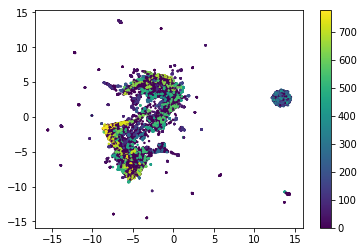

In [2]:
cv = ClusterVerbs(rank=64, clusser_dim=10)
cv.do_cluster()                                                       
cv.write_cluters()                                                    